# Predicting Stroke Likelihood using Patient Data

## Introduction

Strokes are the second leading cause of death globally, and are responsible for around **11%** of total deaths.Early detection of stroke risk can significantly improve preventive care and patient outcomes, reducing the global impact of this health condition. This work aims to address this problem by utilizing data mining techniques to predict the likelihood of patients experiencing a stroke based on certain input parameters. This involves analyzing a dataset containing demographic, health, and lifestyle information to identify key predictors of stroke risk.These data will be used to build and train a predictive model to estimate the risk of a patient getting a stroke. This work may be used to inform healthcare professionals and individuals about potential high-risk profiles, contributing to preventative health measures and strategies. 



## Table of Contents

1. [Data](#data)
    1. [Description of the Data](#dataDescription)
    2. [Data Cleanup and Summary Statistics](#dataSummary)
2. [Exploratory Data Analysis (EDA)](#eda)
    1. [Does the risk of stroke seem to increase with age?](#uni_age)
    2. [Does the risk of stroke seem to differ with Body Mass Index (BMI)?](#uni_bmi)
    3. [Does the risk of stroke seem to differ with Average Glucose Levels?](#uni_glucose)
    4. [Univariate Analysis with Categorical Variables](#uni_cat)
    5. [Risk of stroke as an effect of gender and marital status](#gender_married)
    6. [Risk of stroke as an effect of gender and age](#gender_age)
    7. [Risk of stroke as an effect of gender and employer type](#gender_work)
    8. [Correlation Matrix](#CorrelationMatrix) 
3. Key Analyses Questions
    1. [How is the risk of stroke associated with smoking status amplified with age?](#age_smoking)
    2. [How is the risk of stroke associated with hypertension amplified with age?](#age_hypertension)
    3. [Risk Profiles: What combinations of predictors contribute most significantly to stroke risk?](#risk_profile)
4. [Predicting Risk of Stroke using Machine Learning Models](#predictive)
5. [Dimensionality Reduction and Principal Component Analysis (PCA)](#pca)
6. [Feature Importance](#ft-interpretation))
7. [Evaluation of Predictive Models](#evaluation)
    1. [Interpretation of Model Evaluation](#interpretation)


### Import Libraries

In [305]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.decomposition import PCA



<a id = "data"></a>
# About the Data

<a id = "dataDescription"></a>
## Description of the Data
Includes a numerical and contextual description of the source data

| Attribute          | Description |
|:--------------------|:-------------|
| id                 | A unique identifier assigned to each patient in the dataset. |
| gender             | The gender of the patient, which can be "Male", "Female", or "Other". |
| age                | The age of the patient |
| hypertension       | Indicates the presence of hypertension, where 0 means the patient does not have hypertension and 1 means the patient has hypertension. |
| heart_disease      | Denotes whether the patient has any heart diseases, with 0 representing no heart diseases and 1 indicating the presence of heart disease. |
| ever_married       | A binary indicator showing marital status, where "No" means the patient has never been married and "Yes" indicates they have been married. |
| work_type          | Describes the employment type of the patient, which includes categories like "children", "Govt_job", "Never_worked", "Private", or "Self-employed". |
| Residence_type     | The living environment of the patient, categorized as "Rural" or "Urban". |
| avg_glucose_level  | Average blood glucose level of the patient |
| bmi                | Body Mass Index of the patient, a key metric for assessing whether a person has a healthy body weight for their height. |
| smoking_status     | The smoking habits of the patient, with possible values being "formerly smoked", "never smoked", "smokes", or "Unknown" for cases where the information is unavailable. |
| stroke             | Indicates whether the patient had a stroke, with 1 representing a stroke occurrence and 0 meaning no stroke. |


In [306]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [307]:
print("Dimensions of the source data: ", df.shape, "\n\n", "Data Types")
df.info()

Dimensions of the source data:  (5110, 12) 

 Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


<a id = "dataSummary"></a>
### Data Cleanup and Summary Statistics
Binning some variables to make it more interpretable

In [308]:
df['bmi_cat'] = pd.cut(df['bmi'], bins = [0, 19, 25,30,10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
df['age_cat'] = pd.cut(df['age'], bins = [0,13,18,45,65,200], labels = ['Children (Ages 0-12)', 'Teens (Ages 13-18)', 'Young Adults (Ages 18-45)','Middle-Aged Adults (Ages 45-65)','Elderly(Age 65+)'])
df['glucose_cat'] = pd.cut(df['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])


### Statistical Summary of Numerical Data

In [309]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


### Statistical Summary of Categorical Data

In [310]:
df.describe(include="object").T

,count,unique,top,freq
gender,5110,3,Female,2994
ever_married,5110,2,Yes,3353
work_type,5110,5,Private,2925
Residence_type,5110,2,Urban,2596
smoking_status,5110,4,never smoked,1892


<a id = "eda"></a>
## Exploratory Data Analysis (EDA)

### Univariate Analyses
The following visuals are meant to elucidate the relationship between each variable and the stroke likelihood. In order to know whether the percentages observed are valid, total counts and population breakdown is also visualized.


<a id = "uni_age"></a>
### Does the risk of stroke seem to increase with age?

/var/folders/1b/j76d7t_x6x368p87p_6jtjbm0000gn/T/ipykernel_3784/610593973.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['stroke'] == 0], x='age', ax=ax, shade=True, alpha=1, color='#49762B', label='Healthy')
/var/folders/1b/j76d7t_x6x368p87p_6jtjbm0000gn/T/ipykernel_3784/610593973.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['stroke'] == 1], x='age', ax=ax, shade=True, alpha=0.8, color='#92140C', label='Stroke')


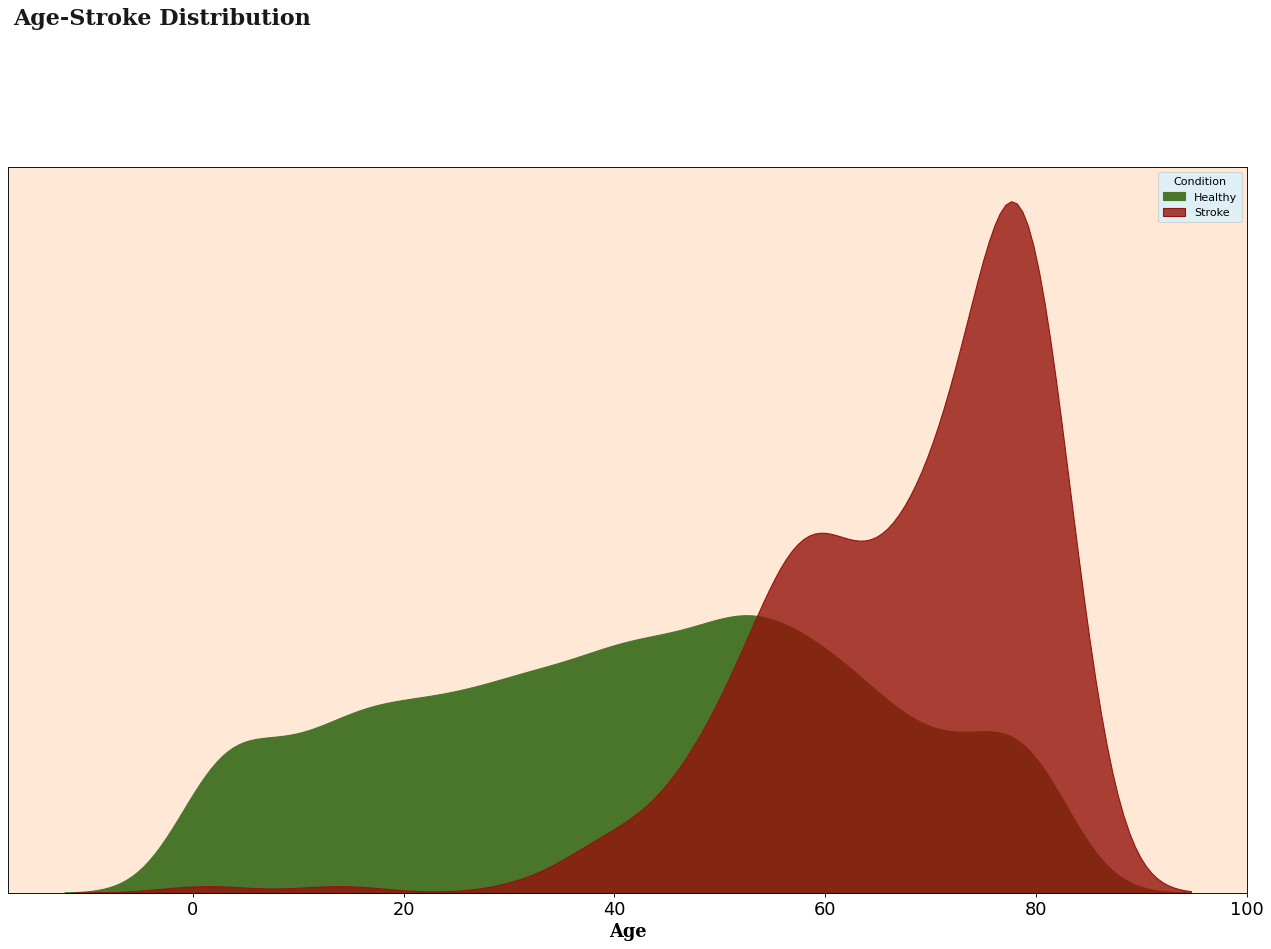

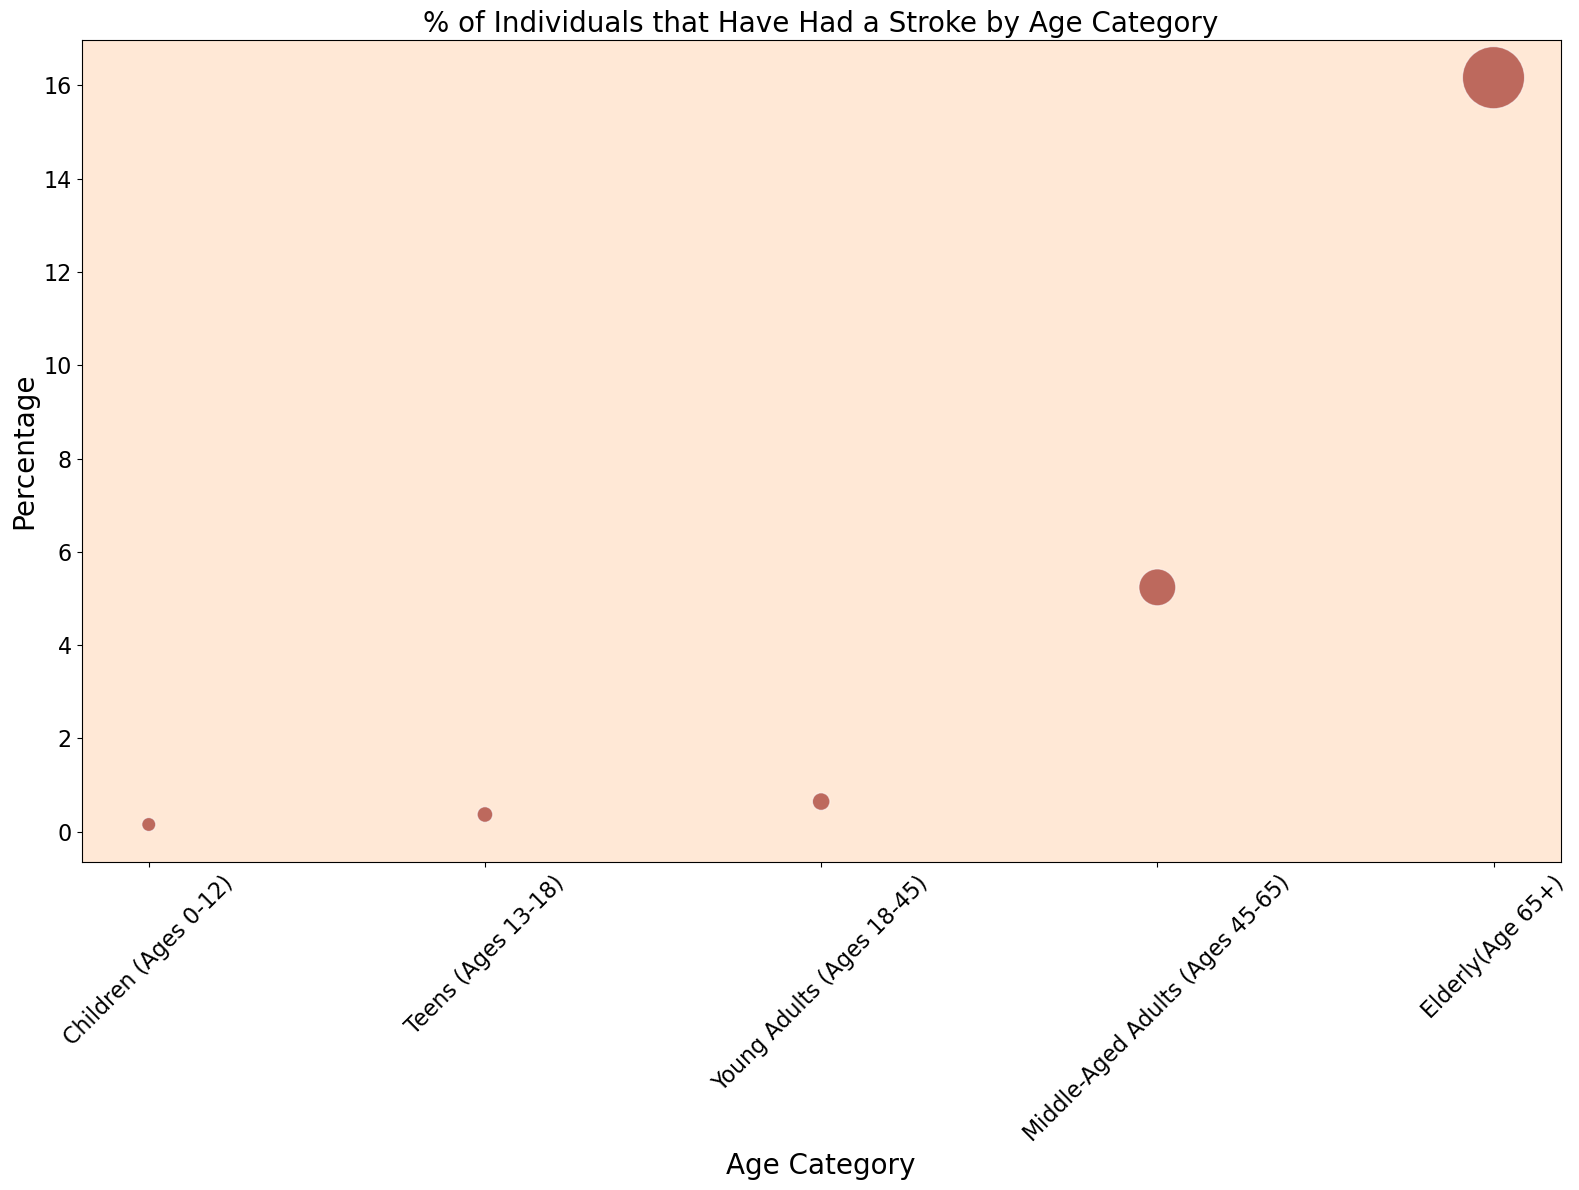

The significant left-skew present in the distribution of individuals that have had a stroke suggests that there may be a positive correlation between age and stroke risk.
The second visual showing the stroke percentage by age group reflects the same trend.


In [311]:
plt.figure(figsize=(16, 12), dpi=80)
ax = plt.gca()
ax.set_facecolor('#FFE8D6')  

sns.kdeplot(data=df[df['stroke'] == 0], x='age', ax=ax, shade=True, alpha=1, color='#49762B', label='Healthy')
sns.kdeplot(data=df[df['stroke'] == 1], x='age', ax=ax, shade=True, alpha=0.8, color='#92140C', label='Stroke')

ax.set_xlabel('Age', fontdict={'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 16})
ax.axes.get_yaxis().set_visible(False)

ax.text(-17, 0.05, 'Age-Stroke Distribution', {'font': 'Serif', 'weight': 'bold', 'color': 'black', 'size': 20}, alpha=0.9)
plt.xticks(fontsize=16)
ax.legend(title='Condition')

plt.tight_layout()
plt.show()

stroke_percentages_df = (df.groupby('age_cat')['stroke'].mean() * 100).reset_index(name='percentage')

plt.figure(figsize=(16, 12))
plt.gca().set_facecolor('#FFE8D6') 
sns.scatterplot(data=stroke_percentages_df, x='age_cat', y='percentage', size='percentage', legend=False, sizes=(100, 2000), alpha=0.6, color='#92140C')
plt.title('% of Individuals that Have Had a Stroke by Age Category', fontsize=20)
plt.xlabel('Age Category', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.gca().axes.get_yaxis().set_visible(True)  
plt.yticks(fontsize=16)


plt.tight_layout()
plt.show()

print('The significant left-skew present in the distribution of individuals that have had a stroke suggests that there may be a positive correlation between age and stroke risk.')
print('The second visual showing the stroke percentage by age group reflects the same trend.')




<a id = "uni_bmi"></a>
### Does the risk of stroke seem to differ with BMI?

/var/folders/1b/j76d7t_x6x368p87p_6jtjbm0000gn/T/ipykernel_3784/3630618458.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['stroke'] == 0], x='bmi', ax=ax, shade=True, alpha=1, color='#49762B', label='Healthy')
/var/folders/1b/j76d7t_x6x368p87p_6jtjbm0000gn/T/ipykernel_3784/3630618458.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['stroke'] == 1], x='bmi', ax=ax, shade=True, alpha=0.8, color='#92140C', label='Stroke')


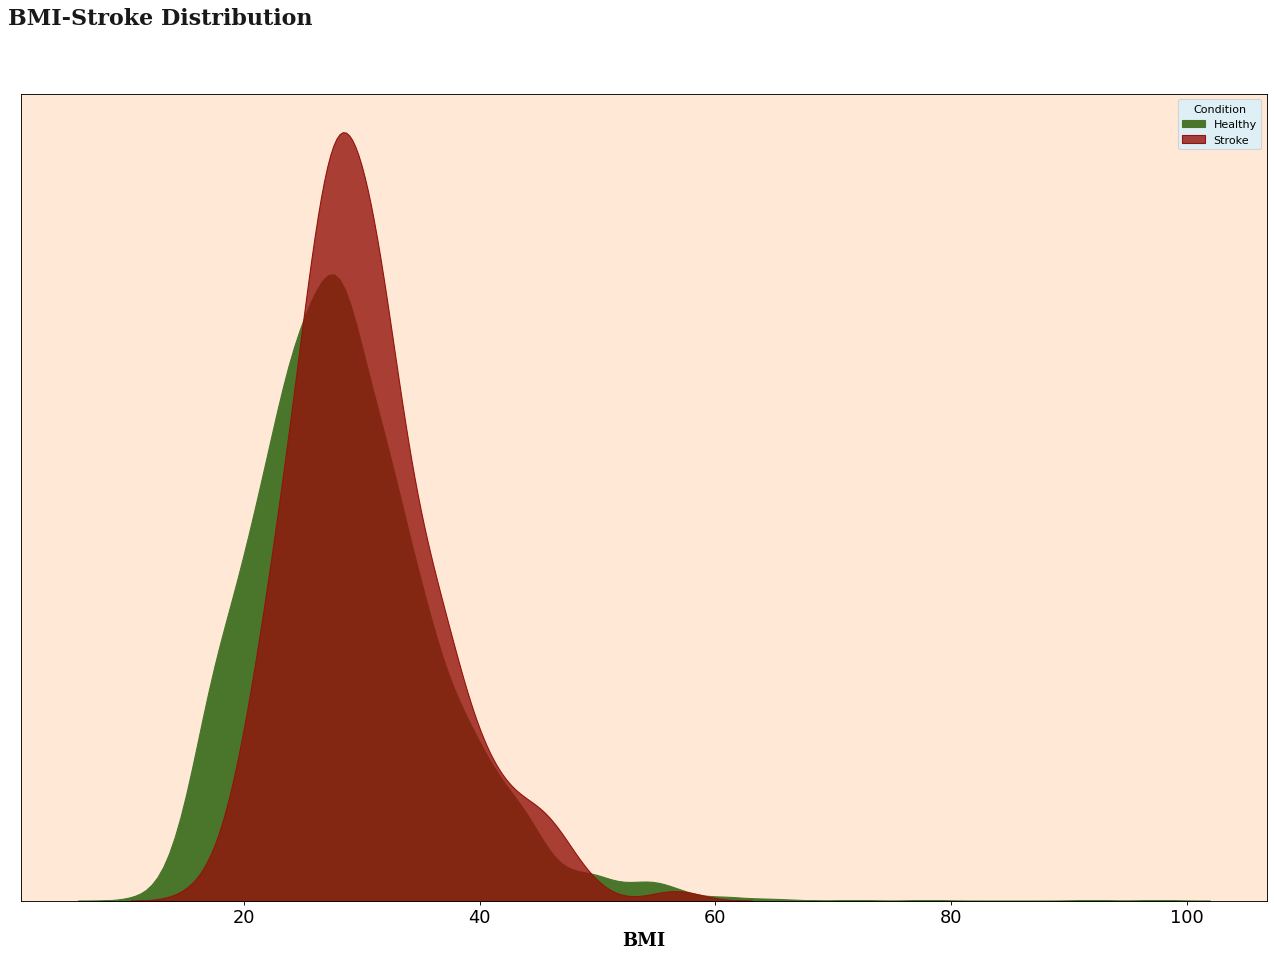

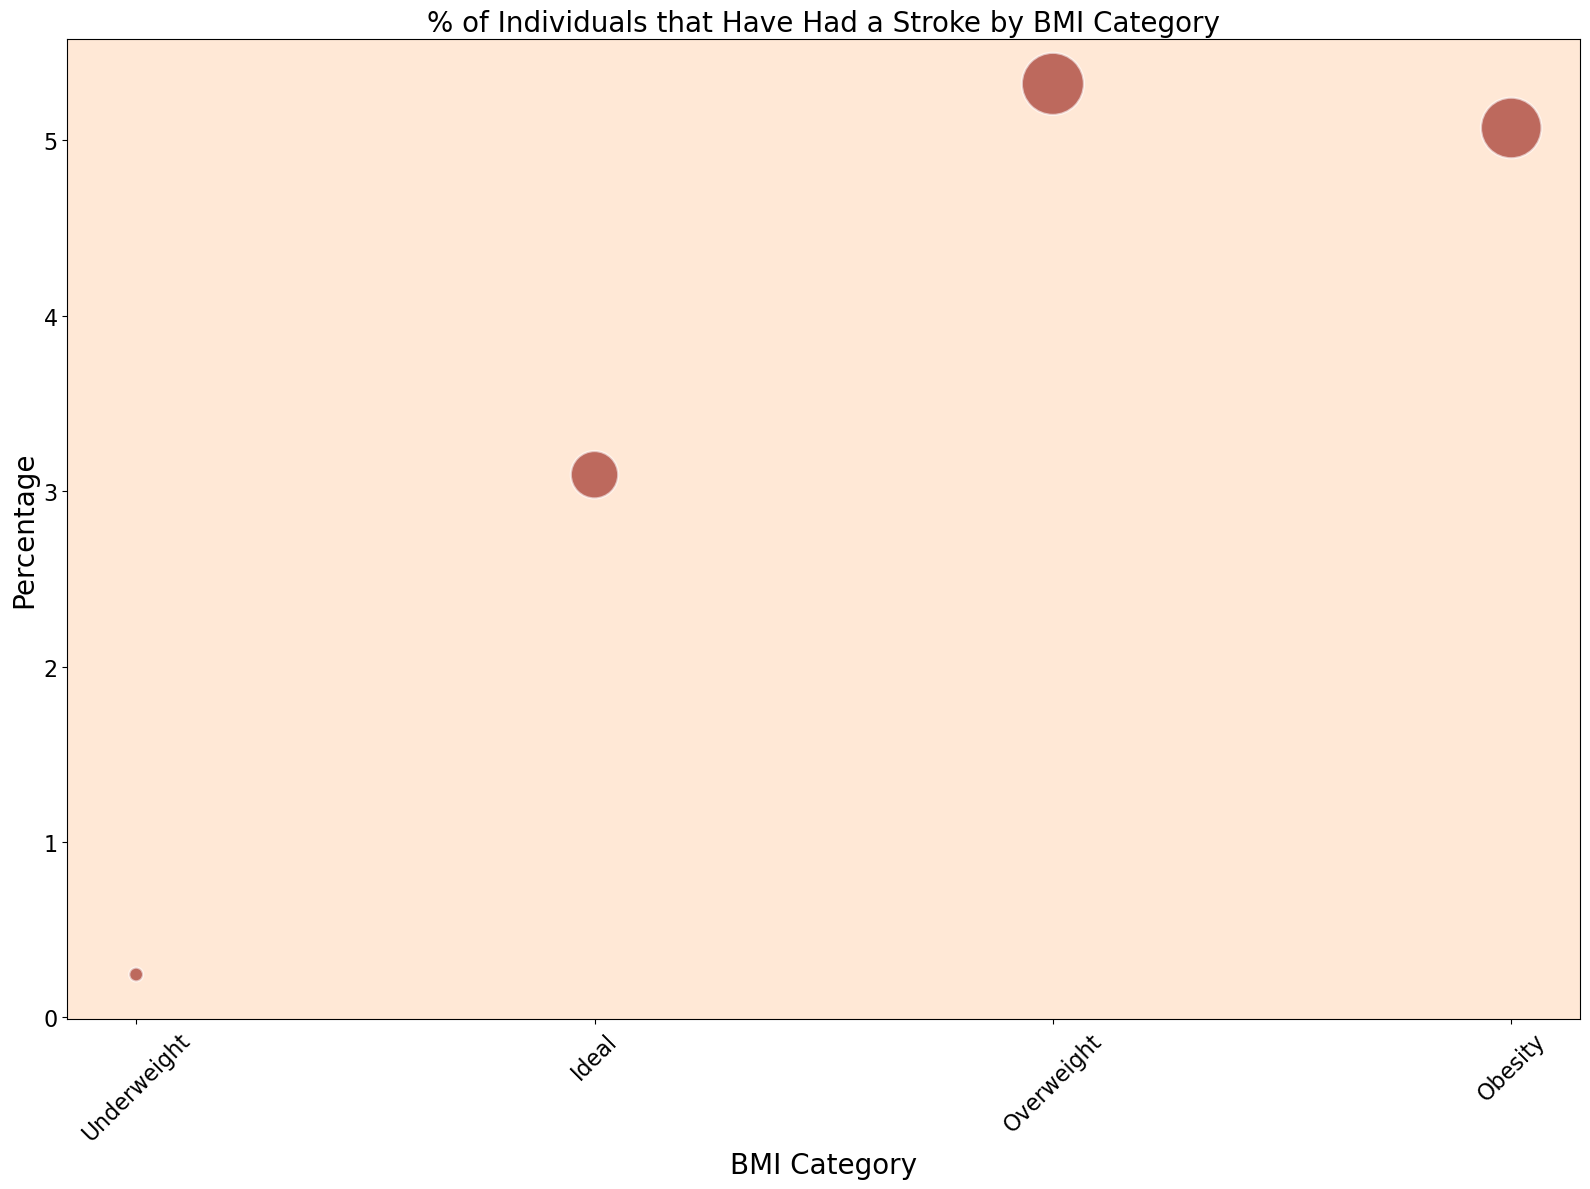

There seems to be a somewhat positive correlaion between Body Mass Index and risk of stroke. As BMI increases, so does the risk of stroke.


In [312]:
plt.figure(figsize=(16, 12), dpi=80)
ax = plt.gca()
ax.set_facecolor('#FFE8D6')

sns.kdeplot(data=df[df['stroke'] == 0], x='bmi', ax=ax, shade=True, alpha=1, color='#49762B', label='Healthy')
sns.kdeplot(data=df[df['stroke'] == 1], x='bmi', ax=ax, shade=True, alpha=0.8, color='#92140C', label='Stroke')

ax.set_xlabel('BMI', fontdict={'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 16})
ax.axes.get_yaxis().set_visible(False)

ax.text(0, 0.08, 'BMI-Stroke Distribution', {'font': 'Serif', 'weight': 'bold', 'color': 'black', 'size': 20}, alpha=0.9)
plt.xticks(fontsize=16)
ax.legend(title='Condition')

plt.tight_layout()
plt.show()

stroke_percentages_df = (df.groupby('bmi_cat')['stroke'].mean() * 100).reset_index(name='percentage')

plt.figure(figsize=(16, 12))
plt.gca().set_facecolor('#FFE8D6') 
sns.scatterplot(data=stroke_percentages_df, x='bmi_cat', y='percentage', size='percentage', legend=False, sizes=(100, 2000), alpha=0.6, color='#92140C')
plt.title('% of Individuals that Have Had a Stroke by BMI Category', fontsize=20)
plt.xlabel('BMI Category', fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.ylabel('Percentage', fontsize=20)
plt.yticks(fontsize=16)
plt.gca().axes.get_yaxis().set_visible(True)

plt.tight_layout()
plt.show()

print('There seems to be a somewhat positive correlaion between Body Mass Index and risk of stroke. As BMI increases, so does the risk of stroke.')



<a id = "uni_glucose"></a>
### Does the risk of stroke seem to differ with Glucose levels?

/var/folders/1b/j76d7t_x6x368p87p_6jtjbm0000gn/T/ipykernel_3784/256638843.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['stroke'] == 0], x='avg_glucose_level', ax=ax, shade=True, alpha=1, color='#49762B', label='Healthy')
/var/folders/1b/j76d7t_x6x368p87p_6jtjbm0000gn/T/ipykernel_3784/256638843.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[df['stroke'] == 1], x='avg_glucose_level', ax=ax, shade=True, alpha=0.8, color='#92140C', label='Stroke')


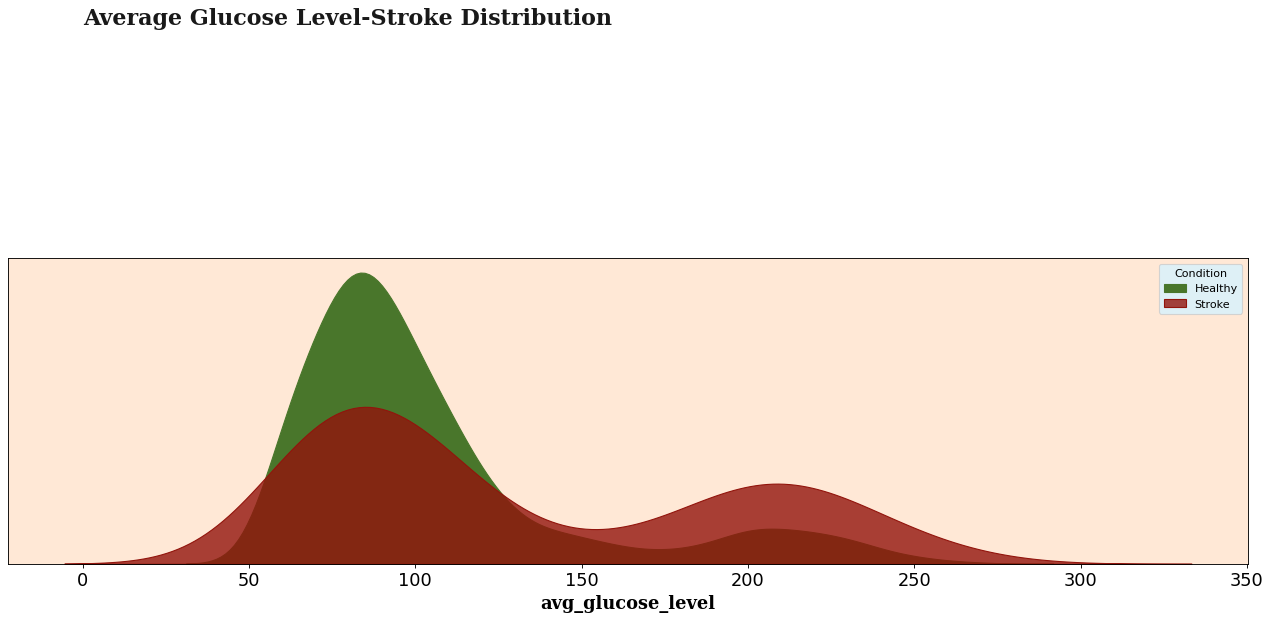

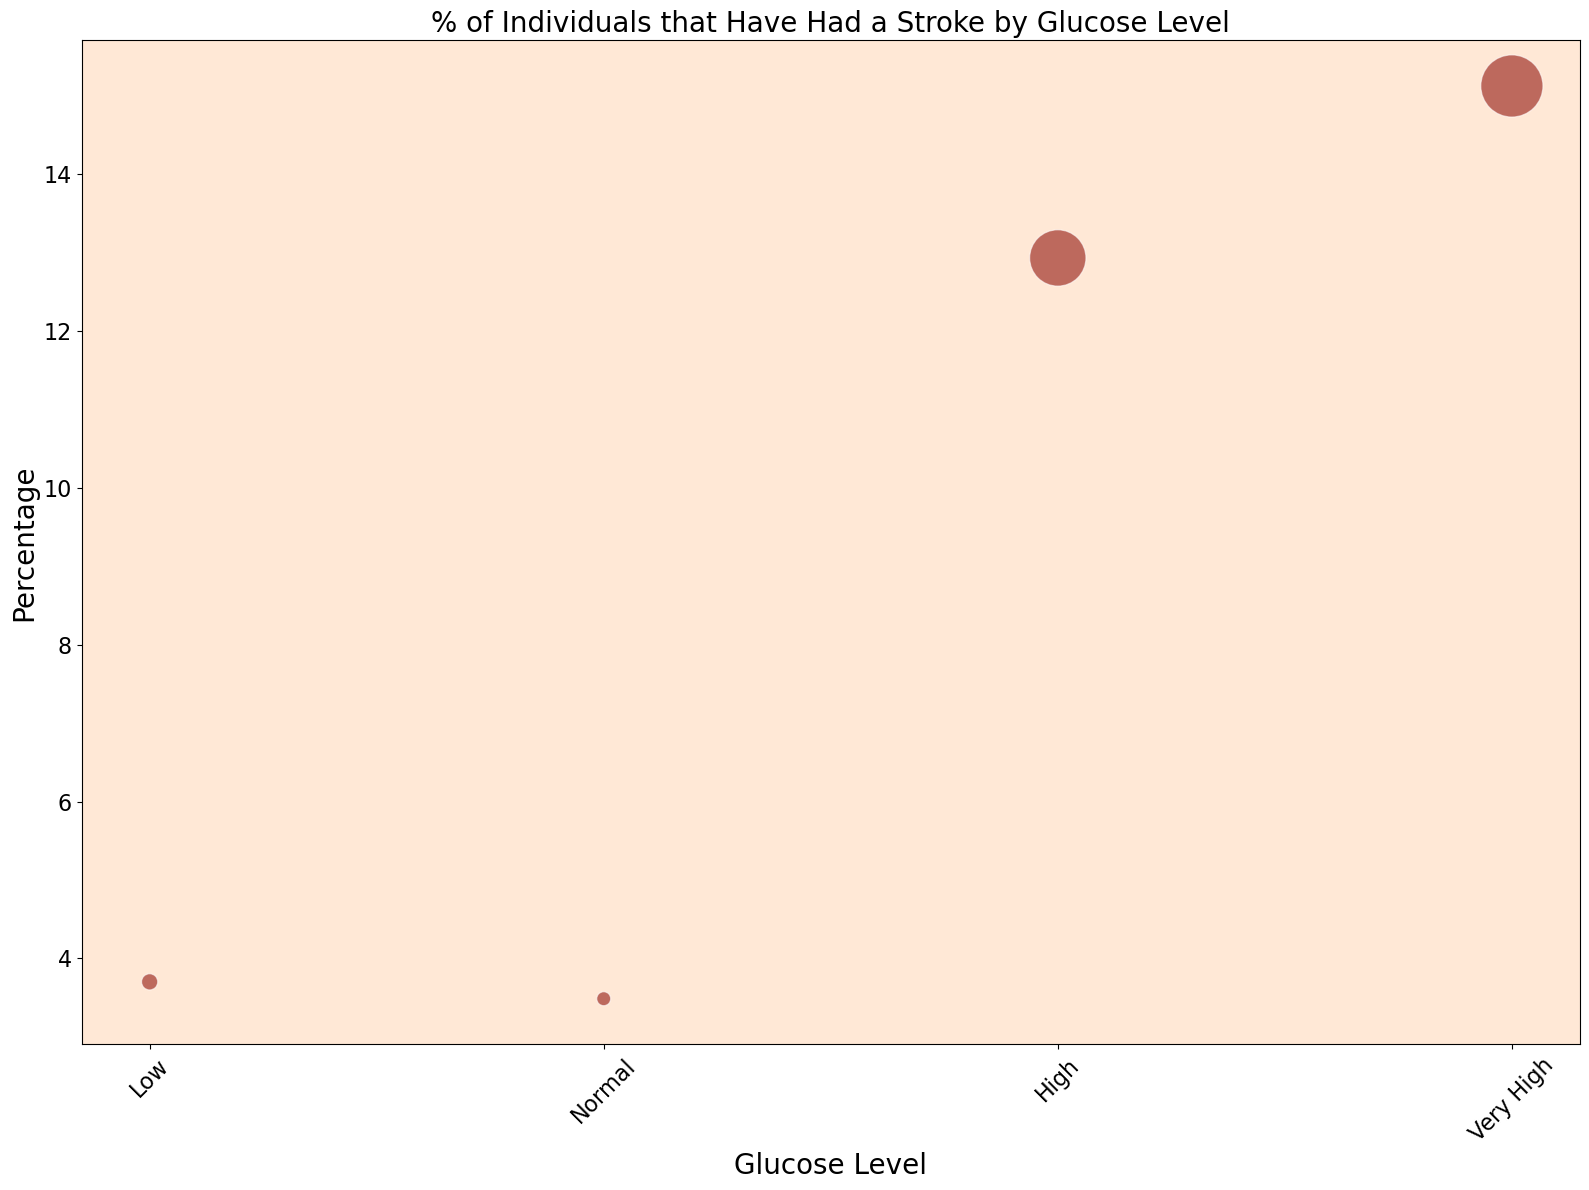

There seems to be a somewhat positive correlaion between Glucose Levels and risk of stroke, and higher glucose levels are correlated with higher risk of stroke.


In [313]:
plt.figure(figsize=(16, 12), dpi=80)
ax = plt.gca()
ax.set_facecolor('#FFE8D6')

sns.kdeplot(data=df[df['stroke'] == 0], x='avg_glucose_level', ax=ax, shade=True, alpha=1, color='#49762B', label='Healthy')
sns.kdeplot(data=df[df['stroke'] == 1], x='avg_glucose_level', ax=ax, shade=True, alpha=0.8, color='#92140C', label='Stroke')

ax.set_xlabel('avg_glucose_level', fontdict={'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 16})
ax.axes.get_yaxis().set_visible(False)

ax.text(0, 0.03, 'Average Glucose Level-Stroke Distribution', {'font': 'Serif', 'weight': 'bold', 'color': 'black', 'size': 20}, alpha=0.9)
plt.xticks(fontsize=16)
ax.legend(title='Condition')

plt.tight_layout()
plt.show()

stroke_percentages_df = (df.groupby('glucose_cat')['stroke'].mean() * 100).reset_index(name='percentage')

plt.figure(figsize=(16, 12))
plt.gca().set_facecolor('#FFE8D6')
sns.scatterplot(data=stroke_percentages_df, x='glucose_cat', y='percentage', size='percentage', legend=False, sizes=(100, 2000), alpha=0.6, color='#92140C')
plt.title('% of Individuals that Have Had a Stroke by Glucose Level', fontsize=20)
plt.xlabel('Glucose Level', fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.ylabel('Percentage', fontsize=20)
plt.yticks(fontsize=16)
plt.gca().axes.get_yaxis().set_visible(True)

plt.tight_layout()
plt.show()

print('There seems to be a somewhat positive correlaion between Glucose Levels and risk of stroke, and higher glucose levels are correlated with higher risk of stroke.')



<a id = "uni_cat"></a>
### Univariate analysis of categorical variables
#### Does the risk of stroke vary with the following predictors:
1. Gender
2. Presence of Hypertension
3. Presence of Heart disease
4. Marital Status
5. Employer type (work_type)
6. Whether they live in an urban or rural setting
7. Current Smoking Status

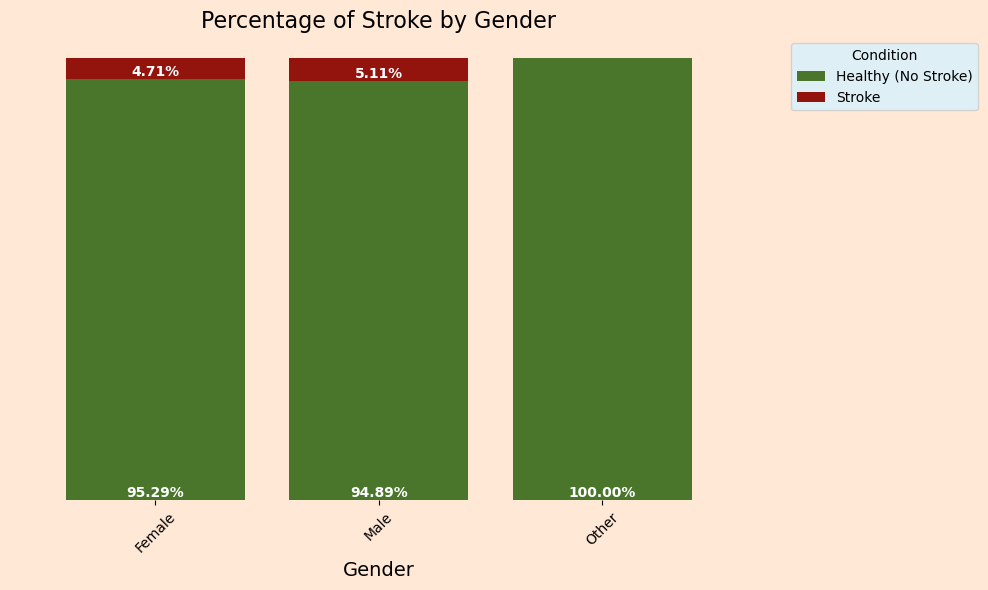

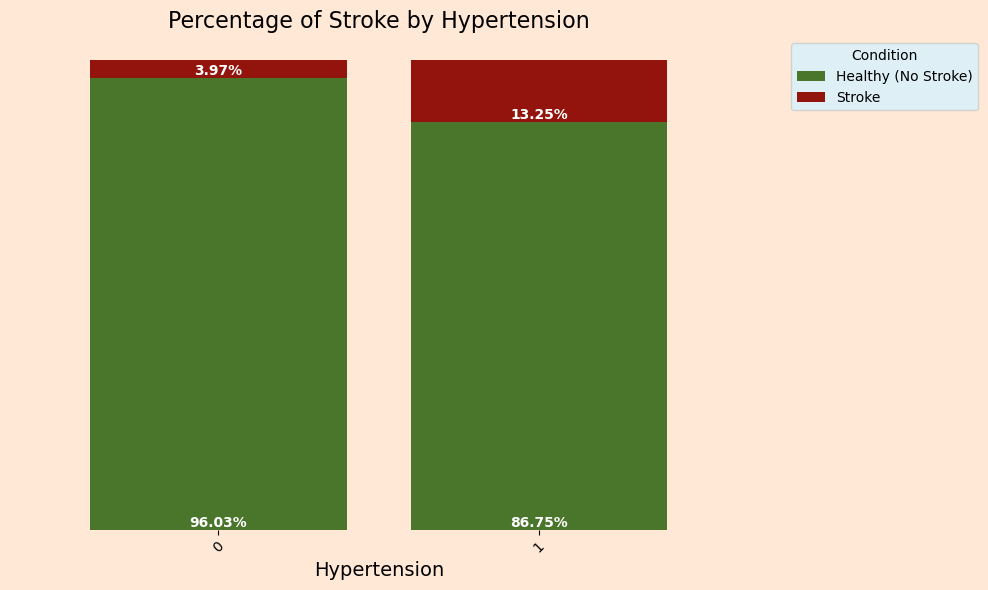

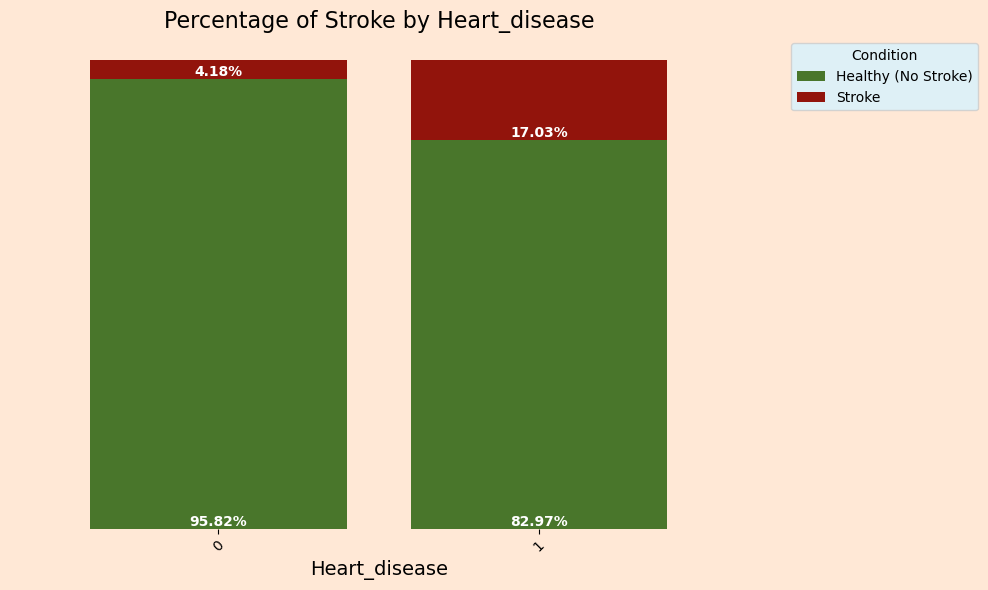

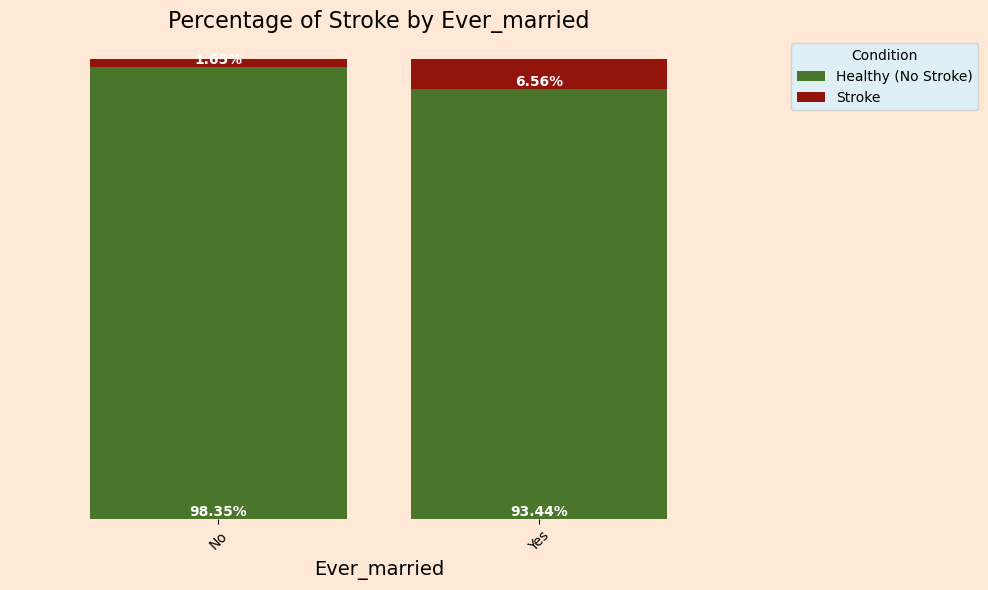

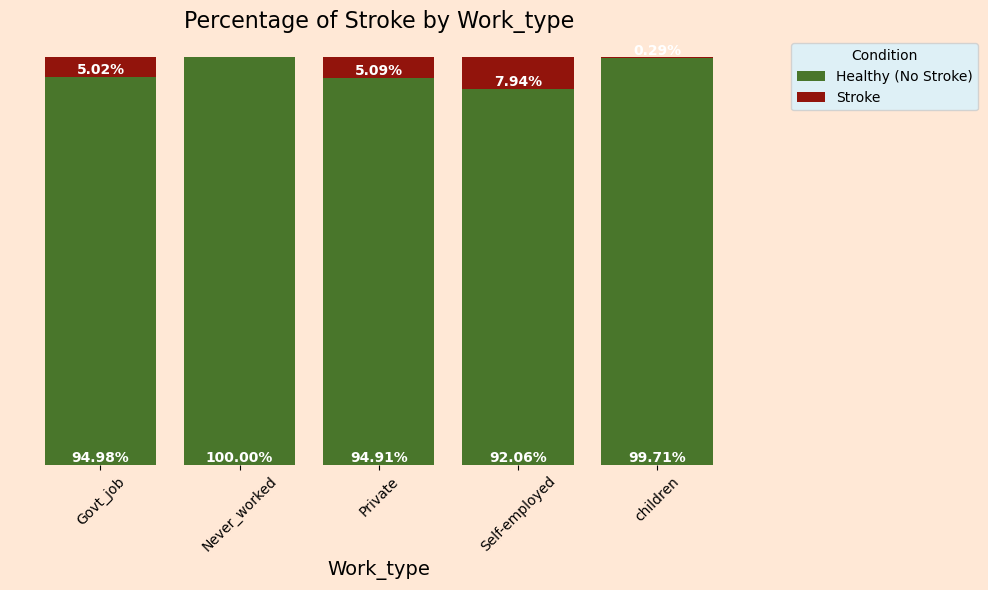

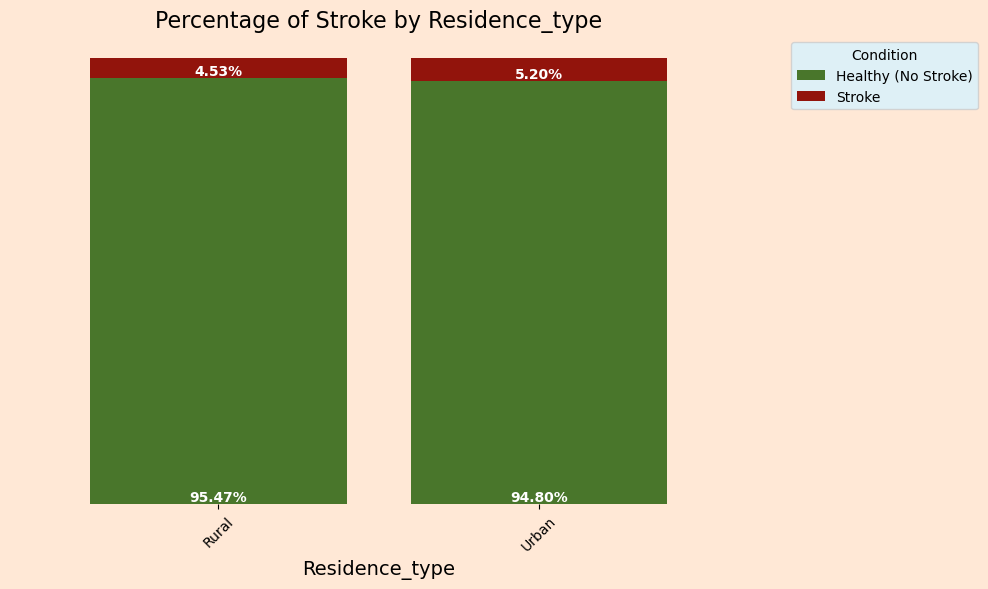

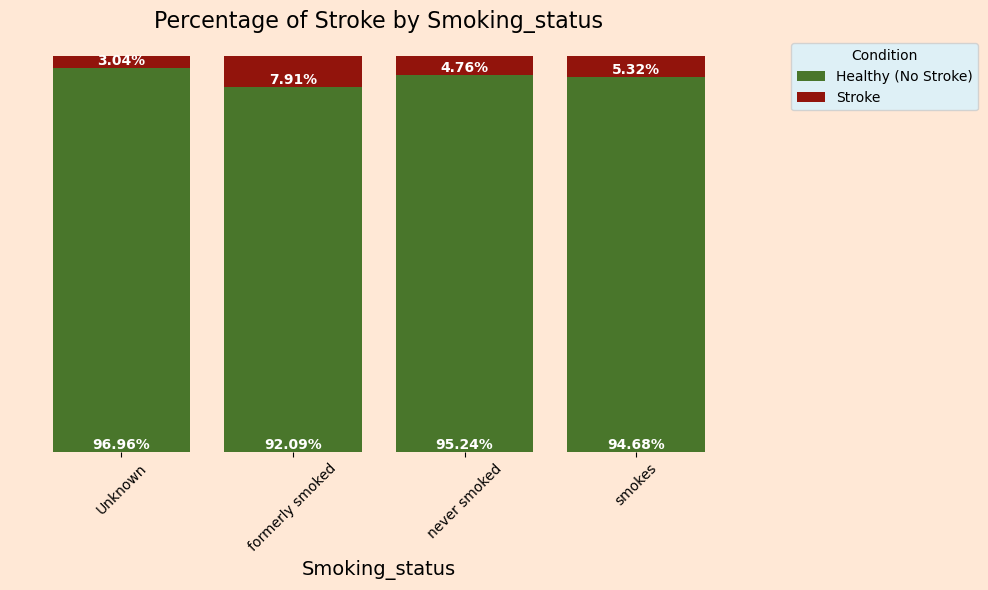

Gender and residence type (urban/rural) does not appear to influence stroke risk.
The presence of hypertension and/or heart disease seems to increase stroke risk significantly (stat-sig to be determined).
Marital status, employer type, and smoking status also seem to influence the risk of stroke (stat-sig to be determined).


In [314]:
categorical_variables = ['gender', 'hypertension','heart_disease', 'ever_married','work_type', 'Residence_type', 'smoking_status']  
for category in categorical_variables:
    category_percentage = df.groupby([category, 'stroke']).size().unstack().fillna(0)
    category_percentage = category_percentage.div(category_percentage.sum(axis=1), axis=0) * 100

    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    fig = plt.gcf()
    
    ax.set_facecolor('#FFE8D6')
    fig.patch.set_facecolor('#FFE8D6')

    bars = category_percentage.plot(kind='bar', stacked=True, color=['#49762B', '#92140C'], width=0.8, ax=ax)

    plt.title(f'Percentage of Stroke by {category.capitalize()}', fontsize=16)
    plt.xlabel(category.capitalize(), fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(['Healthy (No Stroke)', 'Stroke'], title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
    sns.despine(left=True, bottom=True)
    ax.axes.get_yaxis().set_visible(False)

    for rect in bars.patches:
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        if y + height > 50: 
            label_text = f'{height:.2f}%'  
            label_x = x + width / 2  
            label_y = y 
            ax.text(label_x, label_y, label_text, ha='center', va='bottom', color='white', fontweight='bold')

    plt.tight_layout()
    plt.show()
    
print("Gender and residence type (urban/rural) does not appear to influence stroke risk.")
print("The presence of hypertension and/or heart disease seems to increase stroke risk significantly (stat-sig to be determined).")
print("Marital status, employer type, and smoking status also seem to influence the risk of stroke (stat-sig to be determined).")




<a id = "gender_married"></a>
### Risk of stroke as an effect of gender and marital status

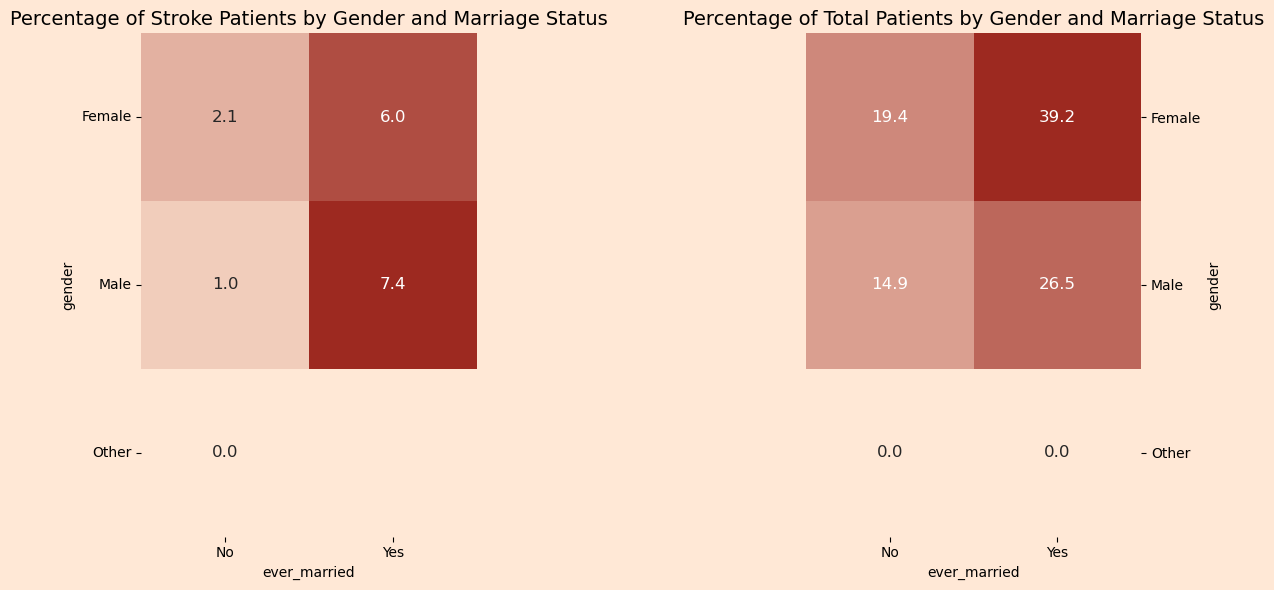

Married individuals are more at risk of getting a stroke, however, the dataset also has a relatively larger sample of married individuals compared to single individuals.


In [315]:
col1 = ["#FFE8D6", "#92140C"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1)
stroke_counts = pd.crosstab(df['gender'], df['ever_married'], values=df['stroke'], aggfunc='sum', dropna=False).fillna(0)
total_counts = pd.crosstab(df['gender'], df['ever_married'])

stroke_percentage = (stroke_counts / total_counts) * 100

total_percentage = (total_counts / total_counts.sum().sum()) * 100

col1 = ["#FFE8D6", "#92140C"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

fig.patch.set_facecolor('#FFE8D6')
for ax in axes:
    ax.set_facecolor('#FFE8D6')

sns.heatmap(data=stroke_percentage, ax=axes[0], linewidths=0, square=True, cbar=False, cmap=colormap1, annot=True, fmt='.1f', annot_kws={"fontsize":12}, alpha=0.9)
axes[0].set_title('Percentage of Stroke Patients by Gender and Marriage Status', fontsize=14)
axes[0].set_xticklabels(['No', 'Yes'])
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

sns.heatmap(data=total_percentage, ax=axes[1], linewidths=0, square=True, cbar=False, cmap=colormap1, annot=True, fmt='.1f', annot_kws={"fontsize":12}, alpha=0.9)
axes[1].set_title('Percentage of Total Patients by Gender and Marriage Status', fontsize=14)
axes[1].set_xticklabels(['No', 'Yes'])
axes[1].set_yticklabels(['Female', 'Male', 'Other'], rotation=0)

axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")

plt.tight_layout()
plt.show()

print("Married individuals are more at risk of getting a stroke, however, the dataset also has a relatively larger sample of married individuals compared to single individuals.")



<a id = "gender_age"></a>
### Risk of stroke as an effect of gender and age

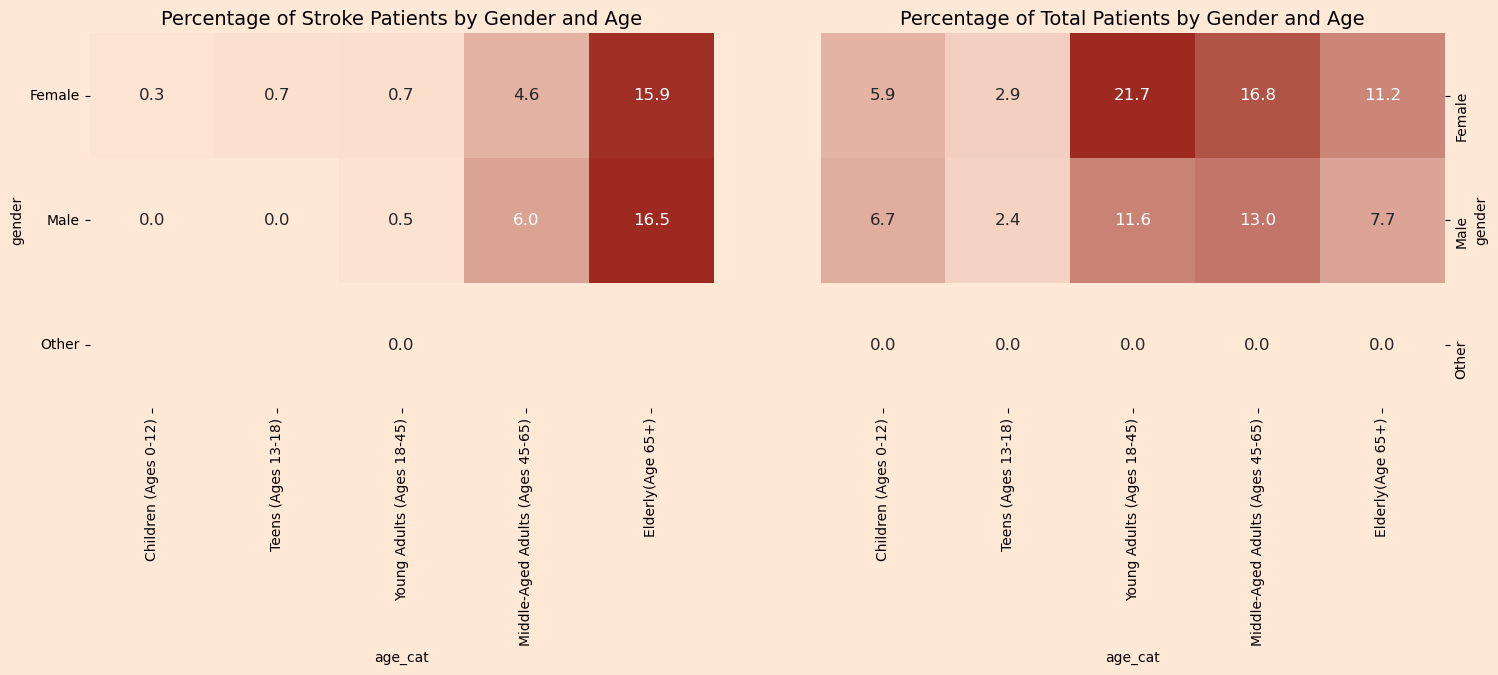

Stroke risk seems to increase with age irrespective of gender, however males seem more at risk for stroke in general


In [316]:
col1 = ["#FFE8D6", "#92140C"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1)
stroke_counts = pd.crosstab(df['gender'], df['age_cat'], values=df['stroke'], aggfunc='sum', dropna=False).fillna(0)
total_counts = pd.crosstab(df['gender'], df['age_cat'])

stroke_percentage = (stroke_counts / total_counts) * 100

total_percentage = (total_counts / total_counts.sum().sum()) * 100

col1 = ["#FFE8D6", "#92140C"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

fig.patch.set_facecolor('#FFE8D6')
for ax in axes:
    ax.set_facecolor('#FFE8D6')

sns.heatmap(data=stroke_percentage, ax=axes[0], linewidths=0, square=True, cbar=False, cmap=colormap1, annot=True, fmt='.1f', annot_kws={"fontsize":12}, alpha=0.9)
axes[0].set_title('Percentage of Stroke Patients by Gender and Age', fontsize=14)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

sns.heatmap(data=total_percentage, ax=axes[1], linewidths=0, square=True, cbar=False, cmap=colormap1, annot=True, fmt='.1f', annot_kws={"fontsize":12}, alpha=0.9)
axes[1].set_title('Percentage of Total Patients by Gender and Age', fontsize=14)

axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")

plt.tight_layout()
plt.show()

print("Stroke risk seems to increase with age irrespective of gender, however males seem more at risk for stroke in general")



<a id = "gender_work"></a>
### Risk of stroke as an effect of gender and employer type

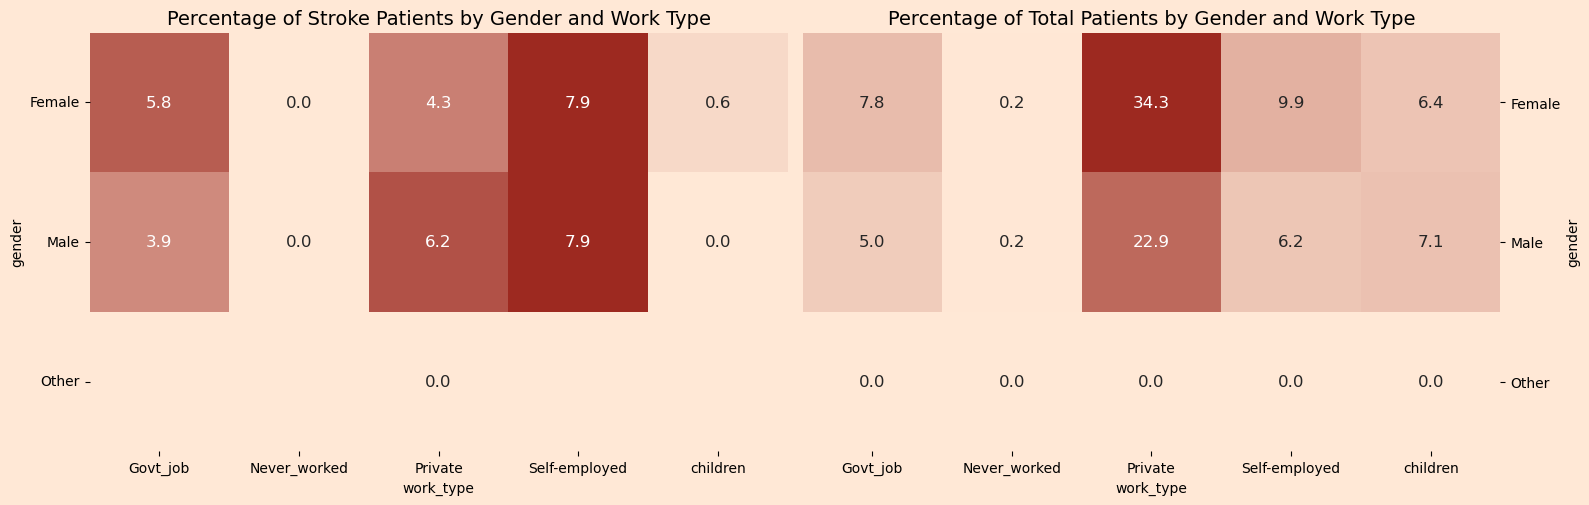

Self employed individuals seem to have the highest risk of stroke though they are relatively underrepresented in the data.
Men working in the pricate sector and women working government jobs have relatively higher risk of stroke.
Note: Private sector employees are relatively overrepresented in the data.


In [317]:


col1 = ["#FFE8D6", "#92140C"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1)
stroke_counts = pd.crosstab(df['gender'], df['work_type'], values=df['stroke'], aggfunc='sum', dropna=False).fillna(0)
total_counts = pd.crosstab(df['gender'], df['work_type'])

stroke_percentage = (stroke_counts / total_counts) * 100

total_percentage = (total_counts / total_counts.sum().sum()) * 100

col1 = ["#FFE8D6", "#92140C"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

fig.patch.set_facecolor('#FFE8D6')
for ax in axes:
    ax.set_facecolor('#FFE8D6')

sns.heatmap(data=stroke_percentage, ax=axes[0], linewidths=0, square=True, cbar=False, cmap=colormap1, annot=True, fmt='.1f', annot_kws={"fontsize":12}, alpha=0.9)
axes[0].set_title('Percentage of Stroke Patients by Gender and Work Type', fontsize=14)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

sns.heatmap(data=total_percentage, ax=axes[1], linewidths=0, square=True, cbar=False, cmap=colormap1, annot=True, fmt='.1f', annot_kws={"fontsize":12}, alpha=0.9)
axes[1].set_title('Percentage of Total Patients by Gender and Work Type', fontsize=14)
axes[1].set_yticklabels(['Female', 'Male', 'Other'], rotation=0)

axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")

plt.tight_layout()
plt.show()


print("Self employed individuals seem to have the highest risk of stroke though they are relatively underrepresented in the data.")
print("Men working in the pricate sector and women working government jobs have relatively higher risk of stroke.")
print("Note: Private sector employees are relatively overrepresented in the data.")



<a id = "age_smoking"></a>
### How is the effect of smoking status amplified with age


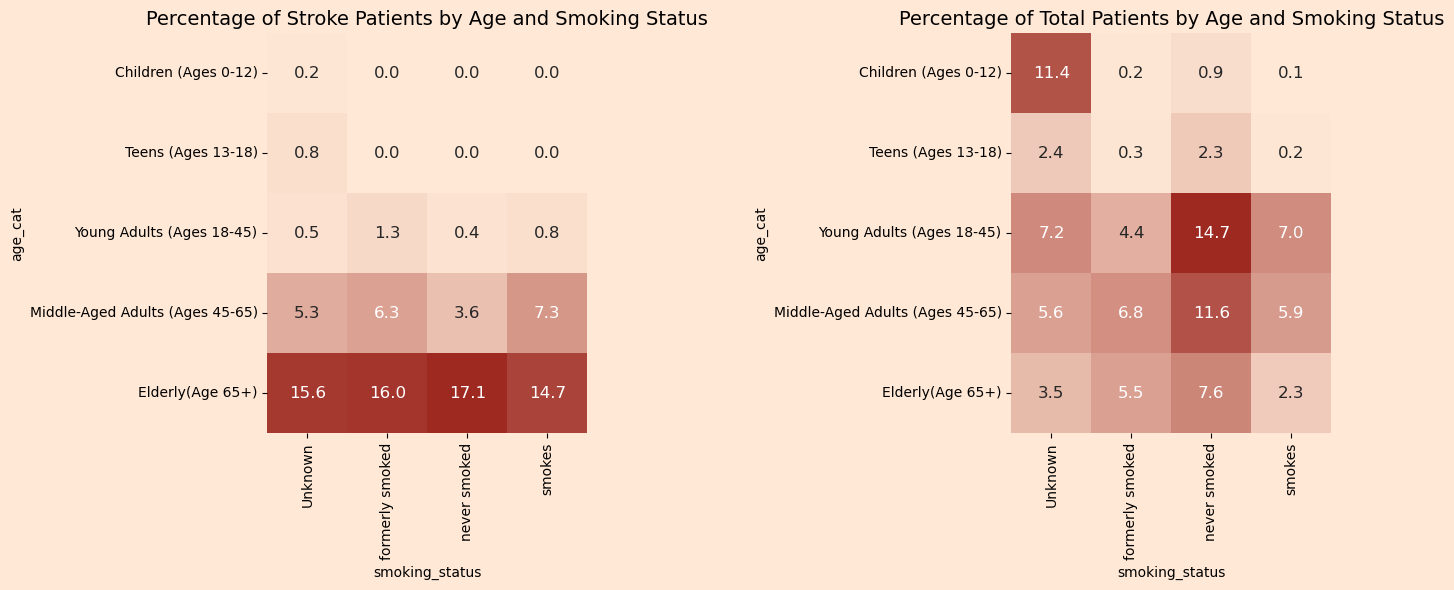

While the risk of stroke increases with age irrespective of smoking status, smoking does seem to increase the likelihood of getting a stroke in adults. The data is relatively balanced across the adult population.


In [318]:
col1 = ["#FFE8D6", "#92140C"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1)


col1 = ["#FFE8D6", "#92140C"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1)
stroke_counts = pd.crosstab(df['age_cat'], df['smoking_status'], values=df['stroke'], aggfunc='sum', dropna=False).fillna(0)
total_counts = pd.crosstab(df['age_cat'], df['smoking_status'])

stroke_percentage = (stroke_counts / total_counts) * 100

total_percentage = (total_counts / total_counts.sum().sum()) * 100

col1 = ["#FFE8D6", "#92140C"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

fig.patch.set_facecolor('#FFE8D6')
for ax in axes:
    ax.set_facecolor('#FFE8D6')

sns.heatmap(data=stroke_percentage, ax=axes[0], linewidths=0, square=True, cbar=False, cmap=colormap1, annot=True, fmt='.1f', annot_kws={"fontsize":12}, alpha=0.9)
axes[0].set_title('Percentage of Stroke Patients by Age and Smoking Status', fontsize=14)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

sns.heatmap(data=total_percentage, ax=axes[1], linewidths=0, square=True, cbar=False, cmap=colormap1, annot=True, fmt='.1f', annot_kws={"fontsize":12}, alpha=0.9)
axes[1].set_title('Percentage of Total Patients by Age and Smoking Status', fontsize=14)


plt.tight_layout()
plt.show()

print("While the risk of stroke increases with age irrespective of smoking status, smoking does seem to increase the likelihood of getting a stroke in adults. The data is relatively balanced across the adult population.")



<a id = "age_hypertension"></a>
### How is the effect of hypertension amplified with age

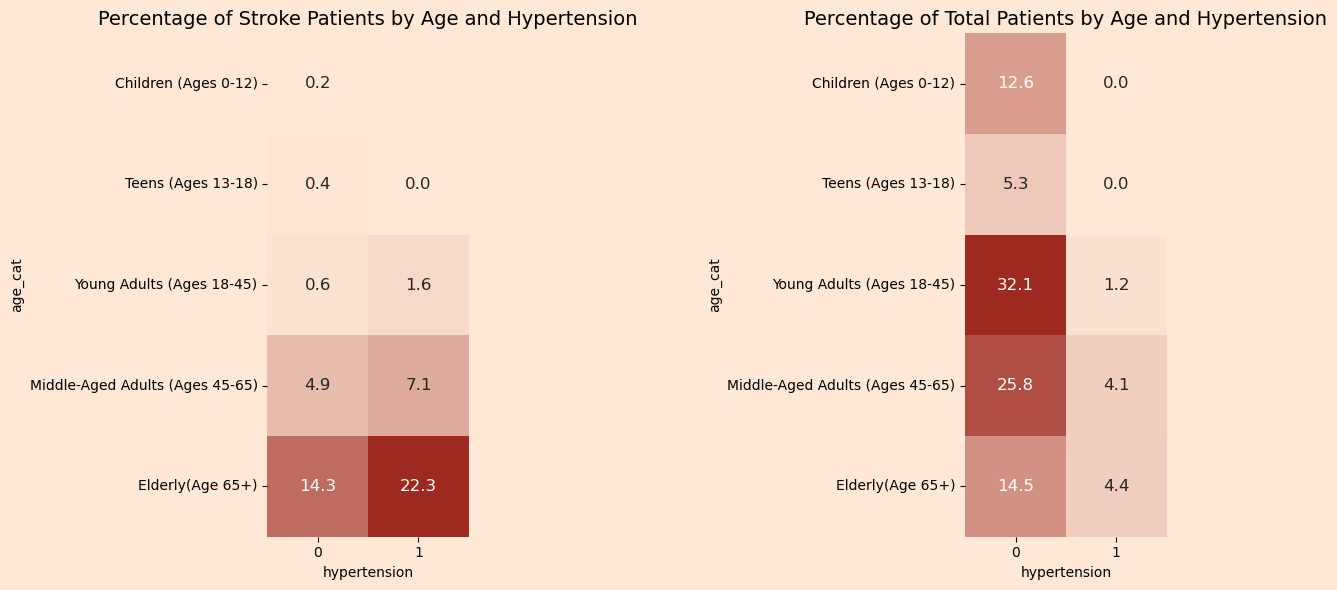

Hypertension seems to have a strong correlation to increasing the risk of stroke. Note that the data is imbalanced (as expected) for hypertension since relatively few will have hypertension compared to those who do not. 


In [319]:
col1 = ["#FFE8D6", "#92140C"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1)


col1 = ["#FFE8D6", "#92140C"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1)
stroke_counts = pd.crosstab(df['age_cat'], df['hypertension'], values=df['stroke'], aggfunc='sum', dropna=False).fillna(0)
total_counts = pd.crosstab(df['age_cat'], df['hypertension'])

stroke_percentage = (stroke_counts / total_counts) * 100

total_percentage = (total_counts / total_counts.sum().sum()) * 100

col1 = ["#FFE8D6", "#92140C"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

fig.patch.set_facecolor('#FFE8D6')
for ax in axes:
    ax.set_facecolor('#FFE8D6')

sns.heatmap(data=stroke_percentage, ax=axes[0], linewidths=0, square=True, cbar=False, cmap=colormap1, annot=True, fmt='.1f', annot_kws={"fontsize":12}, alpha=0.9)
axes[0].set_title('Percentage of Stroke Patients by Age and Hypertension', fontsize=14)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

sns.heatmap(data=total_percentage, ax=axes[1], linewidths=0, square=True, cbar=False, cmap=colormap1, annot=True, fmt='.1f', annot_kws={"fontsize":12}, alpha=0.9)
axes[1].set_title('Percentage of Total Patients by Age and Hypertension', fontsize=14)


plt.tight_layout()
plt.show()

print("Hypertension seems to have a strong correlation to increasing the risk of stroke. Note that the data is imbalanced (as expected) for hypertension since relatively few will have hypertension compared to those who do not. ")


<a id = "risk_profile"></a>
### Risk Profiles: What combinations of predictors contribute most significantly to stroke risk?

In [320]:
from itertools import combinations
factors = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'bmi_cat', 'glucose_cat', 'hypertension', 'heart_disease']

results = []

for r in range(1, len(factors) + 1):
    for subset in combinations(factors, r):
        grouped = df.groupby(list(subset))
        
        for group_keys, group_df in grouped:
            stroke_rate = group_df['stroke'].mean() * 100
            count = group_df.shape[0]
            
            if count >= 50: 
                results.append({
                    'Factors': subset,
                    'Group': group_keys,
                    'Stroke_Rate': stroke_rate,
                    'Count': count
                })

results_df = pd.DataFrame(results)

high_risk_groups = results_df.sort_values(by='Stroke_Rate', ascending=False)

high_risk_groups.head(10)

print("Highest risk profiles for stroke includes individuals above the age of 65, individuals that are overweight and work in the private sector, and those who have heart disease and smoke.")



Highest risk profiles for stroke includes individuals above the age of 65, individuals that are overweight and work in the private sector, and those who have heart disease and smoke.


<a id = "CorrelationMatrix"></a>


### Correlation Matrix


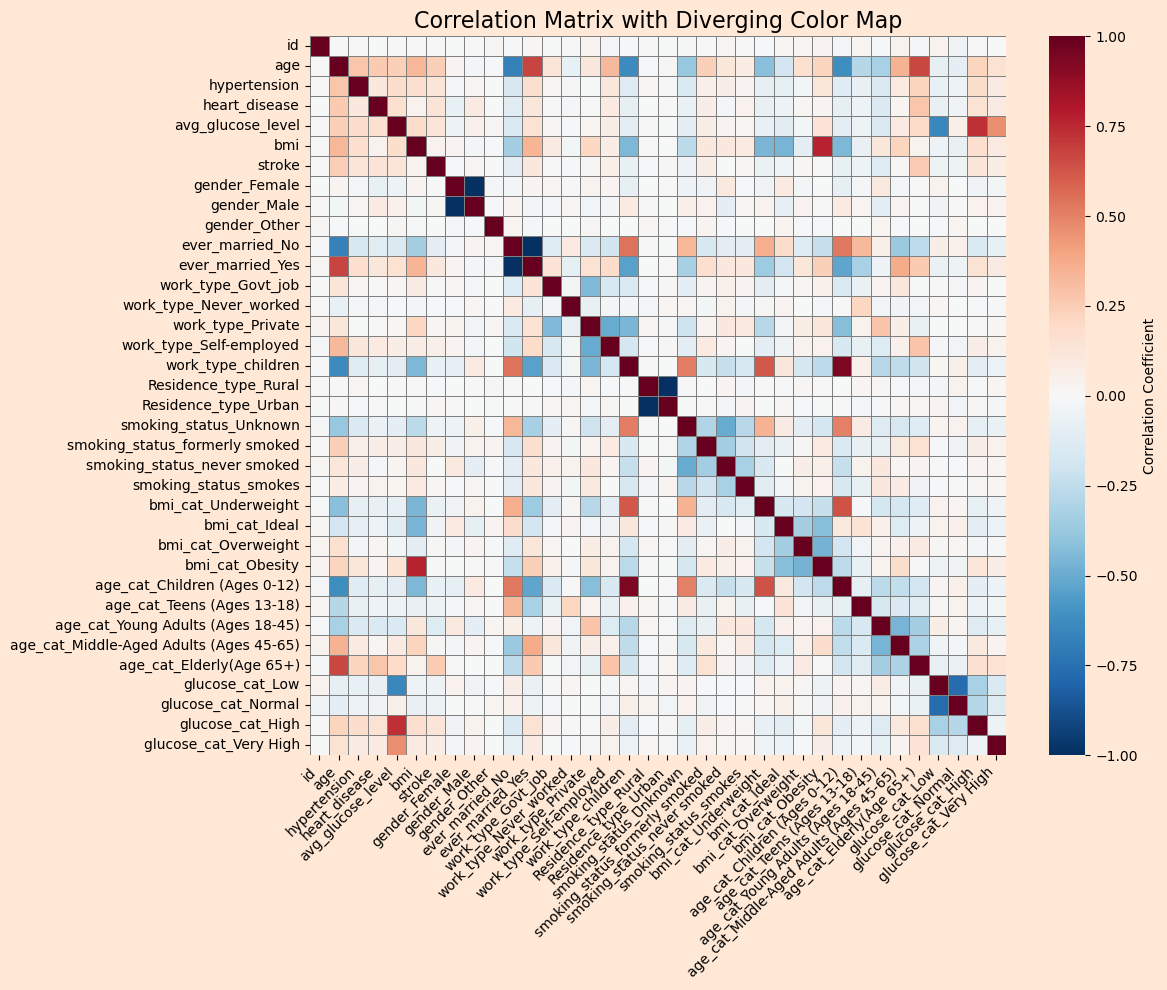

In [321]:

df_numerical = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'bmi_cat', 'age_cat', 'glucose_cat'])
corr = df_numerical.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)  

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='RdBu_r', fmt=".2f", center=0, 
            linewidths=0.5, linecolor='gray', cbar=True, 
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Matrix with Diverging Color Map', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.gcf().set_facecolor('#FFE8D6')
plt.gca().set_facecolor('#FFE8D6')

plt.tight_layout()
plt.show()

<a id = "predictive"></a>
## Predicting Risk of Stroke using Machine Learning Models

In [322]:
df_orig = df.copy(deep=True)

df.drop('id', axis=1, inplace=True)

df.drop(['bmi', 'age', 'avg_glucose_level'], axis=1, inplace=True)

X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

def create_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Deep Learning': KerasClassifier(build_fn=create_model, input_dim=len(preprocessor.fit_transform(X_train).T), epochs=100, batch_size=10, verbose=0),
    'Support Vector Classifier': SVC(probability=True),  
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}
model_evaluation_results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    
    predictions = pipeline.predict(X_test)
    proba_predictions = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.predict(preprocessor.transform(X_test))
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, proba_predictions)
    
    model_evaluation_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    })
    

/Users/varshini/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/varshini/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/varshini/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/varshini/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is il

<a id = "pca"></a>
<a id = "feature"></a>
## Dimensionality Reduction and Feature Importance

In [323]:
#PCA
print("Evaluation whether Dimension Reduction is relevant here, by checking if Principal Component Analysis increases model accuracy.")


if 'Random Forest' in models:
    model = models['Random Forest']
    pca_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('model', model)
])

    pca_pipeline.fit(X_train, y_train)

    predictions = pca_pipeline.predict(X_test)
    accuracy_with_pca = accuracy_score(y_test, predictions)
    print(f"Accuracy with PCA: {accuracy_with_pca:.4f}")

    non_pca_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    non_pca_pipeline.fit(X_train, y_train)
    predictions = non_pca_pipeline.predict(X_test)
    accuracy_without_pca = accuracy_score(y_test, predictions)
    print(f"Accuracy without PCA: {accuracy_without_pca:.4f}")

    if accuracy_with_pca > accuracy_without_pca:
        print("PCA led to an improvement in accuracy.")
    else:
        print("PCA did not improve accuracy.")
   
    cat_features = pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
    features = np.append(numerical_cols, cat_features)
    
    #Feature Importance
    trained_model = non_pca_pipeline.named_steps['model']
    feature_names = np.array(numerical_cols.tolist() + 
                             non_pca_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols).tolist())
    importances = trained_model.feature_importances_

    indices = np.argsort(importances)[::-1]

    print("\n")
    print("Top 20 feature importances:")
    for i in range(20):
        if i < len(indices):
            print(f"{i + 1}. Feature: {feature_names[indices[i]]}, Importance: {importances[indices[i]]:.4f}")
            

Evaluation whether Dimension Reduction is relevant here, by checking if Principal Component Analysis increases model accuracy.
Accuracy with PCA: 0.9276
Accuracy without PCA: 0.9276
PCA did not improve accuracy.


Top 20 feature importances:
1. Feature: hypertension, Importance: 0.0685
2. Feature: age_cat_Elderly(Age 65+), Importance: 0.0642
3. Feature: heart_disease, Importance: 0.0574
4. Feature: work_type_Private, Importance: 0.0497
5. Feature: smoking_status_never smoked, Importance: 0.0482
6. Feature: bmi_cat_Obesity, Importance: 0.0466
7. Feature: Residence_type_Urban, Importance: 0.0452
8. Feature: bmi_cat_Overweight, Importance: 0.0445
9. Feature: Residence_type_Rural, Importance: 0.0438
10. Feature: gender_Male, Importance: 0.0438
11. Feature: smoking_status_formerly smoked, Importance: 0.0432
12. Feature: work_type_Self-employed, Importance: 0.0420
13. Feature: gender_Female, Importance: 0.0407
14. Feature: glucose_cat_Normal, Importance: 0.0389
15. Feature: smoking_status_Un

<a id = "ft-interpretation"></a>
### Feature importance results
The most influential factors in predicting risk of stroke seem to be:
1. Age over 65
2. Hypertension or Heart Disease
3. Working in the private sector
4. Smoking Status
5. Being overweight


<a id = "evaluation"></a>
## Evaluation of Predictive Models

In [324]:

evaluation_df = pd.DataFrame(model_evaluation_results)

sorted_evaluation_df = evaluation_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)
print("\n")
print(sorted_evaluation_df.to_string(index=False))



                    Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC
      Logistic Regression  0.939335   0.000000 0.000000  0.000000 0.826798
              Naive Bayes  0.267123   0.075402 0.983871  0.140069 0.825781
        Gradient Boosting  0.939335   0.000000 0.000000  0.000000 0.822161
            Deep Learning  0.919765   0.205882 0.112903  0.145833 0.772488
                  XGBoost  0.926614   0.117647 0.032258  0.050633 0.770144
            Random Forest  0.925636   0.150000 0.048387  0.073171 0.734711
Support Vector Classifier  0.939335   0.000000 0.000000  0.000000 0.732964
      K-Nearest Neighbors  0.940313   0.666667 0.032258  0.061538 0.638894


<a id = "interpretation"></a>
### Interpretation of Evaluation
Logistic regression had the highest ROC-AUC score while the KNN model had the highest accuracy scores. Both Log-Reg and Gradient Boosting Models had relatively high accuracy and ROC-AUC and would be the preferred choice for stroke prediction.